<a href="https://colab.research.google.com/github/Sunauraa/House-Price-predictor/blob/main/First_AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set up môi trường

In [ ]:
!pip install mxnet
!pip install d2l==1.0.3

#Cài để tải file
import os
from d2l import mxnet as d2l
from mxnet import gluon
import zipfile
import tarfile

# Saved in the d2l package for later use
DATA_HUB = dict()

# Saved in the d2l package for later use
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

#Cài đặt neural network
%matplotlib inline
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
import pandas as pd
npx.set_np()

Tải dữ liệu và lưu trữ nó trong đường dẫn .../data

In [ ]:
# Saved in the d2l package for later use
def download(name, cache_dir='../data'):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, "%s doesn't exist" % name
    url, sha1 = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True) # Use os.makedirs instead
    return gluon.utils.download(url, cache_dir, sha1_hash=sha1)

Giải nén file zip/tar + tải tất cả các file trong data_hub về máy

In [ ]:
# Saved in the d2l package for later use
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext == '.tar' or ext == '.gz':
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted'
    fp.extractall(base_dir)
    if folder:
        return base_dir + '/' + folder + '/'
    else:
        return data_dir + '/'

# Saved in the d2l package for later use
def download_all():
    """Download all files in the DATA_HUB"""
    for name in DATA_HUB:
        download(name)

Tải dataset về

In [ ]:
# Saved in the d2l package for later use
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

# Saved in the d2l package for later use
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

Lưu dataset theo file csv để dùng pandas

In [ ]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

"""Xem data
print(train_data.shape)
print(test_data.shape)"""

'Xem data\nprint(train_data.shape)\nprint(test_data.shape)'

Xem hình dáng của data

In [ ]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Xem 4 dòng đầu của data

In [ ]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


Phần ID k cần thiết => bỏ luôn + Gộp cả train_data và test_data

In [ ]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

Chuẩn hóa các cột là số + lấp đầy những giá trị NaN

In [ ]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

One-hot encoding: Biến các giá trị 'apple','orange','grape' thành vector [1,0,0],[0,1,0],[0,0,1]

In [ ]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

Tách train_data và test_data + lấy labels ra

In [ ]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values, dtype=np.float32)
test_features = np.array(all_features[n_train:].values, dtype=np.float32)
train_labels = np.array(train_data.SalePrice.values,
                        dtype=np.float32).reshape(-1, 1)

Gọi hàm loss + khởi tạo neural network không có tầng ẩn

In [ ]:
loss = gluon.loss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

Sử dụng loss này để so sánh mức độ nghiệm trọng của lệch số ( lệch 1000 giữa các giá trị thật > 100000 sẽ khác với lệch 1000 giữa các giá trị < 3000 )

In [ ]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = np.clip(net(features), 1, float('inf'))
    return np.sqrt(2 * loss(np.log(clipped_preds), np.log(labels)).mean())

Hàm train siêu bình thường thoi

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

Chia dữ liệu làm k phần và dùng k-1 phần còn lại để train, 1 phần để test để check xem mô hình này phù hợp chưa

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate((X_train, X_part), axis=0)
            y_train = np.concatenate((y_train, y_part), axis=0)
    return X_train, y_train, X_valid, y_valid

Gập chéo k lần

In [ ]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

Đánh giá mô hình

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

NameError: name 'k_fold' is not defined

ok có vẻ k bị overfitting rồi. Train toàn bộ dữ liệu thoi

In [ ]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='rmse', yscale='log')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).asnumpy()
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train rmse 0.162509


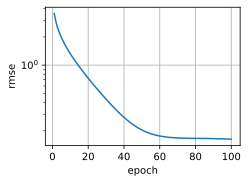

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 7.4 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
